# march-madness-analytics-2020
<br/><br/>
<font size='5' color=green>What do we love in basketball?</font><br/><br/>
<font color=red size='4'>Smooth team play, accurate three-pointer, quiet splashes, beautifull slam dunks, spectacular alley oops, dynamic steals, stopping blocks?</font><br/><br/>

<font size='4'>We love it all, because it releases our emotions.</font><br/><br/>

#### #joy #euphoria #worship #love #pride #hope #relief #disappointment #sadness #helplessness

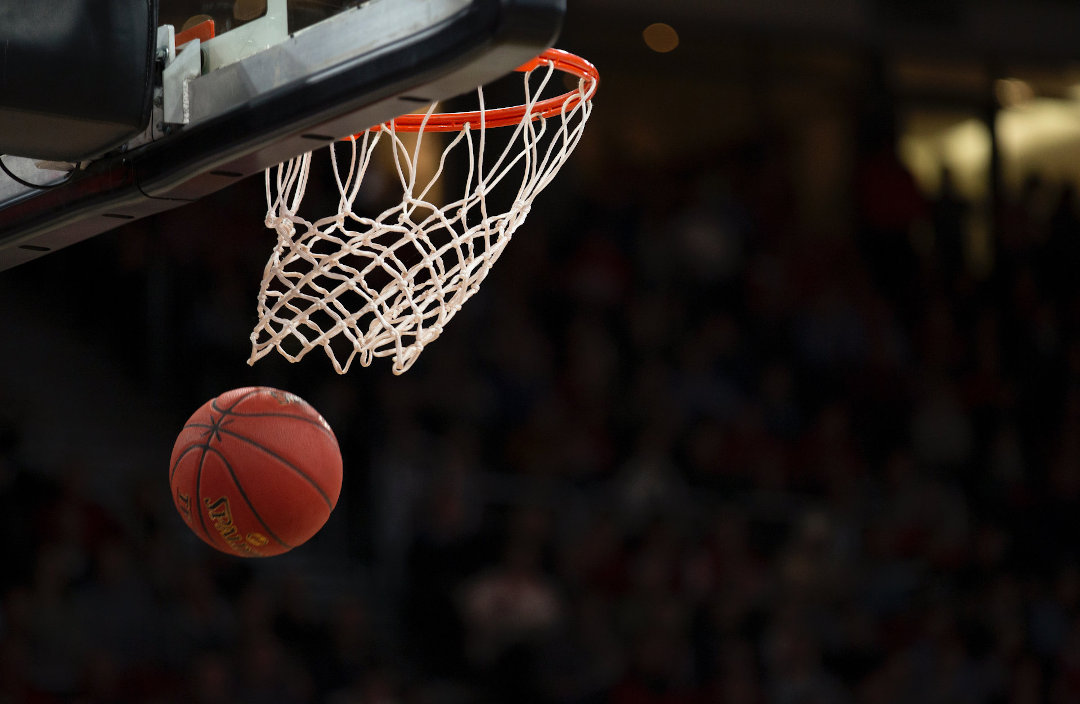

<font size=4>Let's analyze men's and women's games from the seasons 2015-2020 second by second and catch the </font><font size=5 color="red">__thrilling factor__</font>

In [ ]:
import pandas as pd
import numpy as np
import time

First of all I have focused on the final seconds of the games. All offensive and defensive events count.

Then I have looked for these moments during the match, that had a potential to change the leading team. The closer the final buzzer, the more points it added to the thrilling factor.

Additionally I have counted all other moments during the match that wake up the emotions (missed and made points, small score gap). 

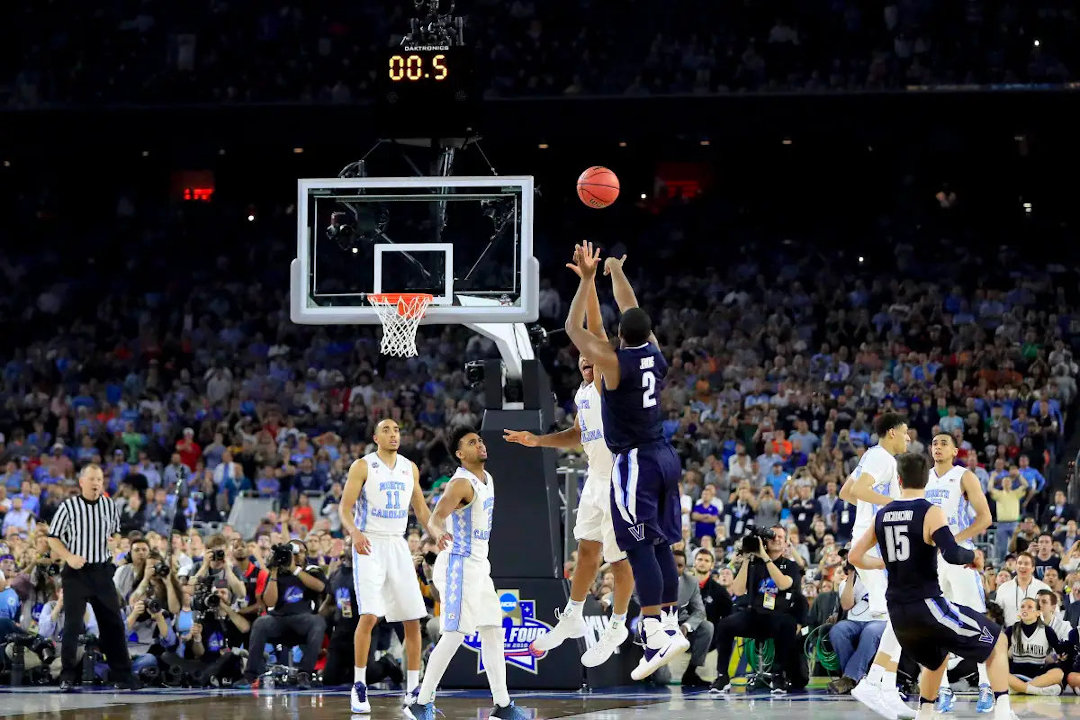
<font size='-1' color='blue'>Villanova's Kris Jenkins hit a shot that will go down in sports history, winning the NCAA men's basketball championship with a three-pointer at the buzzer. *Ronald Martinez/Getty Images (after <a href='https://www.businessinsider.com/kris-jenkins-won-the-greatest-ncaa-championship-game-ever-2016-4?IR=T'>Business Insider</a>)*</font>

In [ ]:
final_seconds = 60
final_seconds_30 = 30
final_seconds_10 = 10
final_seconds_5 = 5
final_seconds_3 = 3
final_seconds_2 = 2
final_seconds_1 = 1
final_seconds_0 = 0

key_columns = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WFinalScore', 'LFinalScore']

In [ ]:
def sort(in_df):
    sort_columns = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'RemainingSeconds']
    in_df.sort_values(by=sort_columns, ascending=[0, 0, 0, 0, 1], axis=0, inplace=True, ignore_index=True)


def count_final_seconds_events(in_df, remaining_seconds, new_col_name):
    print('counting events during final seconds ({}s left) ...'.format(remaining_seconds))
    ending = in_df[in_df['RemainingSeconds'] <= remaining_seconds]
    in_df[new_col_name] = ending.groupby(key_columns)['ElapsedSeconds'].transform('count').fillna(0)


def reward_final_seconds_events(in_df):
    # Final seconds are always beautiful. The more happens here, the more emotions the game releases.
    md1 = in_df['EventType'] == 'made1'
    md2 = in_df['EventType'] == 'made2'
    md3 = in_df['EventType'] == 'made3'
    ms1 = in_df['EventType'] == 'miss1'
    ms2 = in_df['EventType'] == 'miss2'
    ms3 = in_df['EventType'] == 'miss3'
    st1 = in_df['EventType'] == 'steal'
    to1 = in_df['EventType'] == 'turnover'
    rb = in_df['EventType'] == 'reb'
    off = in_df['EventSubType'] == 'off'
    in_dfns = in_df['EventSubType'] == 'def'
    ex = in_df['WFinalScore'] - in_df['LFinalScore'] < 4
    win = in_df['EventTeamID'] == in_df['WTeamID']
    loss = in_df['EventTeamID'] == in_df['LTeamID']
    end = in_df['RemainingSeconds'] <= final_seconds
    print('Calculating points for made 1/2/3 points ...')
    in_df['Made'] = (10.0 / (in_df[(md2 | md3 | md1) & ex & end & win]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    in_df['Made-'] = (5.0 / (in_df[(md2 | md3 | md1) & ex & end & loss]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    print('Calculating points for missed 1/2/3 points ...')
    in_df['Miss'] = (5.0 / (in_df[(ms2 | ms3 | ms1) & ex & end & loss]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    in_df['Miss-'] = (2.5 / (in_df[(ms2 | ms3 | ms1) & ex & end & win]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    print('Calculating points for rebounds ...')
    in_df['RebDef'] = (3.0 / (in_df[rb & in_dfns & ex & end & win]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    in_df['RebOff'] = (3.0 / (in_df[rb & off & ex & end & loss]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    print('Calculating points for steals and turnovers ...')
    in_df['Steal-Turnover-Def'] = (3.0 / (in_df[(st1 | to1) & ex & end & win]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)
    in_df['Steal-Turnover-Hope'] = (3.0 / (in_df[(st1 | to1) & ex & end & loss]['RemainingSeconds'] + 0.3)).fillna(0.0).round(2)


def fill_inter_points(in_df):
    # Calculating current result of the match
    md1 = in_df['EventType'] == 'made1'
    md2 = in_df['EventType'] == 'made2'
    md3 = in_df['EventType'] == 'made3'
    win = in_df['EventTeamID'] == in_df['WTeamID']
    loss = in_df['EventTeamID'] == in_df['LTeamID']

    in_df['WScore'] = in_df[win & (md1 | md2 | md3)]['ScoreAttempt'].fillna(0.0)
    in_df['LScore'] = in_df[loss & (md1 | md2 | md3)]['ScoreAttempt'].fillna(0.0)
    
    gb = in_df.groupby(key_columns)
    in_df['WCurScore'] = gb['WScore'].transform('cumsum').fillna(0)
    in_df['LCurScore'] = gb['LScore'].transform('cumsum').fillna(0)


def count_breaking_moments(in_df):
    # Taking into account the moments during a match when the score gap is small and a loosing team 
    # attempts to throw the points that make this team winning. The closer to the end of the game,
    # the more thrilling these moments are.
    
    print('Calculating inter points ...')
    fill_inter_points(in_df)

    print('Preparing for the break-thru attempts calculations ...')
    md1 = in_df['EventType'] == 'made1'
    md2 = in_df['EventType'] == 'made2'
    md3 = in_df['EventType'] == 'made3'
    ms1 = in_df['EventType'] == 'miss1'
    ms2 = in_df['EventType'] == 'miss2'
    ms3 = in_df['EventType'] == 'miss3'

    break_l = in_df['ScoreAttempt'] >= (in_df['WCurScore']-in_df['WScore']) - (in_df['LCurScore']-in_df['LScore'])
    lead_w = in_df['WCurScore']-in_df['WScore'] >= in_df['LCurScore']-in_df['LScore']
    break_w = in_df['ScoreAttempt'] >= (in_df['LCurScore']-in_df['LScore']) - (in_df['WCurScore']-in_df['WScore'])
    lead_l = in_df['LCurScore']-in_df['LScore'] >= in_df['WCurScore']-in_df['WScore']
    win = in_df['EventTeamID'] == in_df['WTeamID']
    loss = in_df['EventTeamID'] == in_df['LTeamID']
    
    final_seconds_factor = np.maximum(1.0+(final_seconds-in_df['RemainingSeconds'])/12.0, np.array([1]*in_df.shape[0]))

    print('Calculating successful break-thru attempts ...')
    in_df['BreakSuccess'] = (in_df[(md2 | md3 | md1) & ((lead_w & break_l & loss) | (lead_l & break_w & win))]['ScoreAttempt']).fillna(0.0) * final_seconds_factor
    print('Calculating failed break-thru attempts ...')
    in_df['BreakFail'] = (in_df[(ms2 | ms3 | ms1) & ((lead_w & break_l & loss) | (lead_l & break_w & win))]['ScoreAttempt']/2.0).fillna(0.0) * final_seconds_factor


def count_other_match_stats(in_df):
    # made and missed 3- and 2-pointers (during the entire match)
    print('Counting other stats (made/missed throws, score gap) ...')
    md2 = in_df['EventType'] == 'made2'
    md3 = in_df['EventType'] == 'made3'
    ms2 = in_df['EventType'] == 'miss2'
    ms3 = in_df['EventType'] == 'miss3'
    in_df['MadePoints'] = in_df[md3 | md2]['ScoreAttempt'].pow(3.0)/40.0
    in_df['MissPoints'] = in_df[ms3 | ms2]['ScoreAttempt'].pow(2.0)/40.0
    in_df['ScoreGap'] = 40.0/(in_df['WFinalScore']-in_df['LFinalScore'])


def calculate_thrill(in_df):
    print('Summing up all thrill factors ...')
    gb = in_df.groupby(key_columns)

    # max for "EndingEvents"
    in_df['60s'] = gb['EndingEvents60Count'].transform('max')
    in_df['30s'] = gb['EndingEvents30Count'].transform('max')
    in_df['10s'] = gb['EndingEvents10Count'].transform('max')
    in_df['5s'] = gb['EndingEvents5Count'].transform('max')
    in_df['3s'] = gb['EndingEvents3Count'].transform('max')
    in_df['2s'] = gb['EndingEvents2Count'].transform('max')
    in_df['1s'] = gb['EndingEvents1Count'].transform('max')
    in_df['0s'] = gb['EndingEvents0Count'].transform('max')

    # sum for other columns
    print('Summing up final seconds "Made" points ...')
    in_df['Made'] = gb['Made'].transform('sum').round(2)
    in_df['Made-'] = gb['Made-'].transform('sum').round(2)
    print('Summing up final seconds "Miss" points ...')
    in_df['Miss'] = gb['Miss'].transform('sum').round(2)
    in_df['Miss-'] = gb['Miss-'].transform('sum').round(2)
    print('Summing up final seconds "Rebound" points ...')
    in_df['RebDef'] = gb['RebDef'].transform('sum').round(2)
    in_df['RebOff'] = gb['RebOff'].transform('sum').round(2)
    print('Summing up final seconds "Steals" and "Turnovers" points ...')
    in_df['ST-Def'] = gb['Steal-Turnover-Def'].transform('sum').round(2)
    in_df['ST-Hope'] = gb['Steal-Turnover-Hope'].transform('sum').round(2)
    print('Summing up match break-thru moments" ...')
    in_df['BreakS'] = gb['BreakSuccess'].transform('sum')
    in_df['BreakF'] = gb['BreakFail'].transform('sum')
    print('Summing up entire match "Made" points ...')
    in_df['MatchMade'] = gb['MadePoints'].transform('sum')
    print('Summing up entire match "Miss" points ...')
    in_df['MatchMiss'] = gb['MissPoints'].transform('sum')



def event_count_points(event_count, min_count, mean_count):
    min_points = min_count ** 1.5 / mean_count
    return event_count ** 1.5 / mean_count - min_points

In [ ]:
csv_base = '/kaggle/input/march-madness-analytics-2020'
csv_women = []
csv_men = []
for i in range(2015, 2021):
    csv_women.append('{}/WPlayByPlay_Stage2/WEvents{}.csv'.format(csv_base, i))
    csv_men.append('{}/MPlayByPlay_Stage2/MEvents{}.csv'.format(csv_base, i))

csv_women

In [ ]:
def calculate_thrill_factor(csv):
    all_data = None
    for input_file in csv:
        print('\n\nreading a csv {} ...'.format(input_file))
        df = pd.read_csv(input_file)

        # remove games that have incomplete data (event count < 120)
        print('Removing games with incomplete data ...')
        df.fillna('???', inplace=True)
        tmp = df.groupby(by=['Season', 'DayNum', 'WTeamID', 'LTeamID'])['EventType'].transform('count')
        df = df[tmp > 120].dropna()
        # add points for number of events in the game
        print('Adding points for number of events in the game ...')
        df['EventCountPoints'] = df.groupby(by=['Season', 'DayNum', 'WTeamID', 'LTeamID'])['EventType'].transform('count')
        tmp_mean = np.mean(df['EventCountPoints'])
        tmp_min = np.min(df['EventCountPoints'])
        tmp_max = np.max(df['EventCountPoints'])
        df['EventCountPoints'] = event_count_points(df['EventCountPoints'], tmp_min, tmp_mean)

        # add useful columns
        print('adding GameLength column ...')
        df['GameLength'] = df.groupby(key_columns)['ElapsedSeconds'].transform('max')
        print('adding RemainingSeconds column ...')
        df['RemainingSeconds'] = 2400-df['ElapsedSeconds']
        # define various game lengths with extra periods
        game_length_with_extra_period = range(2700, 2400+10*300, 300)
        for game_length in game_length_with_extra_period:
            print('correcting "RemainingSeconds" for matches lasting {} seconds ...'.format(game_length))
            df['RemainingSeconds'].mask(df['RemainingSeconds'] < 0, game_length-df['ElapsedSeconds'], inplace=True)
        print('adding ScoreAttempt column ...')
        df['ScoreAttempt'] = 0
        df.loc[df['EventType'].isin(['made1', 'miss1']), 'ScoreAttempt'] = 1
        df.loc[df['EventType'].isin(['made2', 'miss2']), 'ScoreAttempt'] = 2
        df.loc[df['EventType'].isin(['made3', 'miss3']), 'ScoreAttempt'] = 3
        print('sorting ...')
        # sort by some key columns (ascending) + 'RemainingSeconds' (descending)
        sort(df)

        reward_final_seconds_events(df)

        # count last seconds events
        count_final_seconds_events(df, final_seconds, 'EndingEvents60Count')
        count_final_seconds_events(df, final_seconds_30, 'EndingEvents30Count')
        count_final_seconds_events(df, final_seconds_10, 'EndingEvents10Count')
        count_final_seconds_events(df, final_seconds_5, 'EndingEvents5Count')
        count_final_seconds_events(df, final_seconds_3, 'EndingEvents3Count')
        count_final_seconds_events(df, final_seconds_2, 'EndingEvents2Count')
        count_final_seconds_events(df, final_seconds_1, 'EndingEvents1Count')
        count_final_seconds_events(df, final_seconds_0, 'EndingEvents0Count')

        # count breaking moments
        count_breaking_moments(df)

        # other match stats
        count_other_match_stats(df)

        # final preparation
        calculate_thrill(df)

        # one row per game
        thrill_columns = ['60s', '30s', '10s', '5s', '3s', '2s', '1s', '0s', 'Made', 'Made-', 'Miss', 'Miss-', 'RebDef', 'ST-Def',
                          'ST-Hope', 'BreakS', 'BreakF', 'MatchMiss', 'MatchMade', 'EventCountPoints', 'ScoreGap']
        games = df.drop_duplicates(subset=key_columns, keep='last')[key_columns + thrill_columns]
        games['Thrill'] = games[thrill_columns].sum(axis=1)

        all_data = pd.concat([all_data, games], ignore_index=True)

    return all_data

In [ ]:
women_thrill_df = calculate_thrill_factor(csv_women)
women_thrill_df

In [ ]:
men_thrill_df = calculate_thrill_factor(csv_men)
men_thrill_df

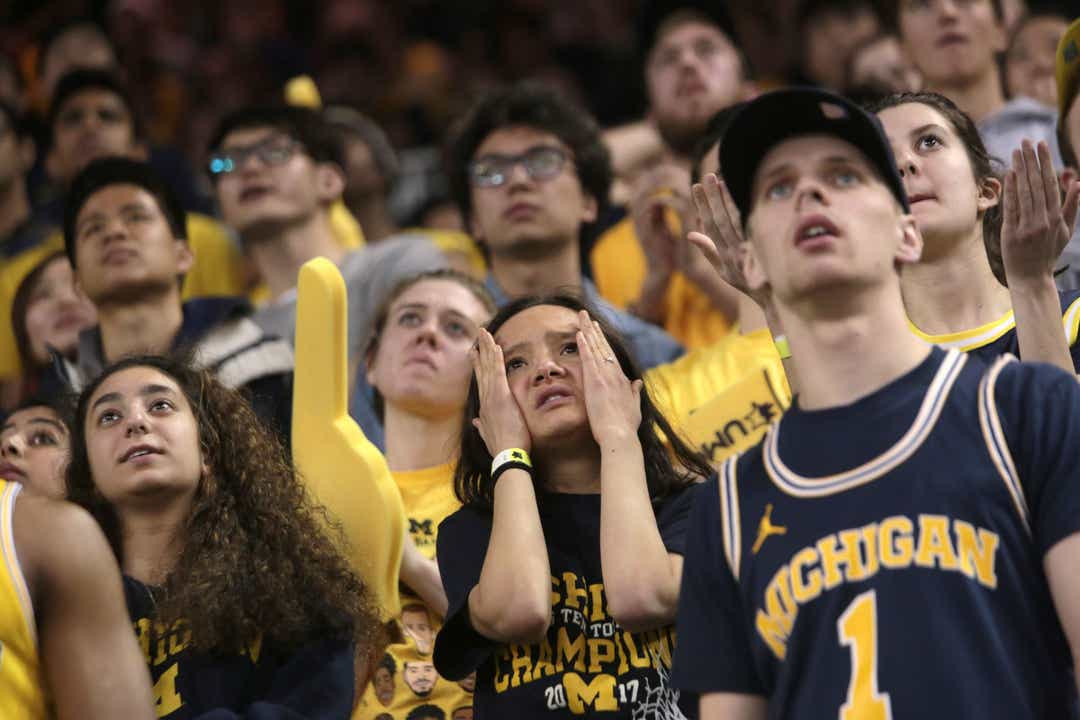
<font size='-1' color="blue">University of Michigan fans watch as their team trails Villanova during the second half on Monday, April 2, 2018 in the NCAA national championship game during a watch party at Crisler Center in Ann Arbor. *Ryan Garza, Detroit Free Press (after <a href='https://eu.freep.com/story/sports/college/university-michigan/2018/04/02/michigan-villanova-national-championship-ncaa-reaction/480419002/'>Detroit Free Press</a>)*</font>

# Let's have a look which teams play in the most thrilling way

In [ ]:
from IPython.display import display, Markdown

def rank_teams_by_thrill(thrill_df, league_gender='W'):
    teams = dict()
    for row in thrill_df.itertuples():
        # count thrill for the winner
        if not row.WTeamID in teams.keys():
            teams[row.WTeamID] = [row.Thrill, 1]
        else:
            teams[row.WTeamID][0] += row.Thrill
            teams[row.WTeamID][1] += 1
        # count thrill for the looser
        if not row.LTeamID in teams.keys():
            teams[row.LTeamID] = [row.Thrill, 1]
        else:
            teams[row.LTeamID][0] += row.Thrill
            teams[row.LTeamID][1] += 1
    team_list = list()
    for t in teams.items():
        team_list.append((t[0], t[1][0]/t[1][1]))
    team_list.sort(key=lambda tup: tup[1], reverse=True)
    team_list_df = pd.DataFrame(team_list, columns=['TeamID', 'AvgGameThrill'])

    # let's match each team id with a team name
    df_teams = pd.read_csv('{f}/{lg}DataFiles_Stage2/{lg}Teams.csv'.format(f=csv_base, lg=league_gender))
    df_thrill_ranking = pd.merge(team_list_df, df_teams, on='TeamID')
    return df_thrill_ranking

In [ ]:
women_ranking = rank_teams_by_thrill(women_thrill_df, 'W')
style1 = '<span style="color:#ffc125"><strong><font size="6">'
style2 = '<span style="color:#C0C0C0"><strong><font size="6">'
style3 = '<span style="color:#cd7f32"><strong><font size="6">'
style_end = '</font></strong></span>'
Markdown("# Women's THRILL ranking<br/><br/>{}1. {} ({}){}<br/><br/>{}2. {} ({}){}<br/><br/>{}3. {} ({}){}<br/><br/><br/><br/>".format(
    style1, women_ranking.loc[0, 'TeamName'], round(women_ranking.loc[0, 'AvgGameThrill'], 1), style_end,
    style2, women_ranking.loc[1, 'TeamName'], round(women_ranking.loc[1, 'AvgGameThrill'], 1), style_end,
    style3, women_ranking.loc[2, 'TeamName'], round(women_ranking.loc[2, 'AvgGameThrill'], 1), style_end,
))

In [ ]:
men_ranking = rank_teams_by_thrill(men_thrill_df, 'M')
style1 = '<span style="color:#ffc125"><strong><font size="6">'
style2 = '<span style="color:#C0C0C0"><strong><font size="6">'
style3 = '<span style="color:#cd7f32"><strong><font size="6">'
style_end = '</font></strong></span>'
Markdown("# Men's THRILL ranking<br/><br/>{}1. {} ({}){}<br/><br/>{}2. {} ({}){}<br/><br/>{}3. {} ({}){}<br/><br/><br/><br/>".format(
    style1, men_ranking.loc[0, 'TeamName'], round(men_ranking.loc[0, 'AvgGameThrill'], 1), style_end,
    style2, men_ranking.loc[1, 'TeamName'], round(men_ranking.loc[1, 'AvgGameThrill'], 1), style_end,
    style3, men_ranking.loc[2, 'TeamName'], round(men_ranking.loc[2, 'AvgGameThrill'], 1), style_end,
))

# Let's take a look at the <font color="red">THRILL</font> factor during the <font color="red">March Madness</font>. Is it different from the all-season one?

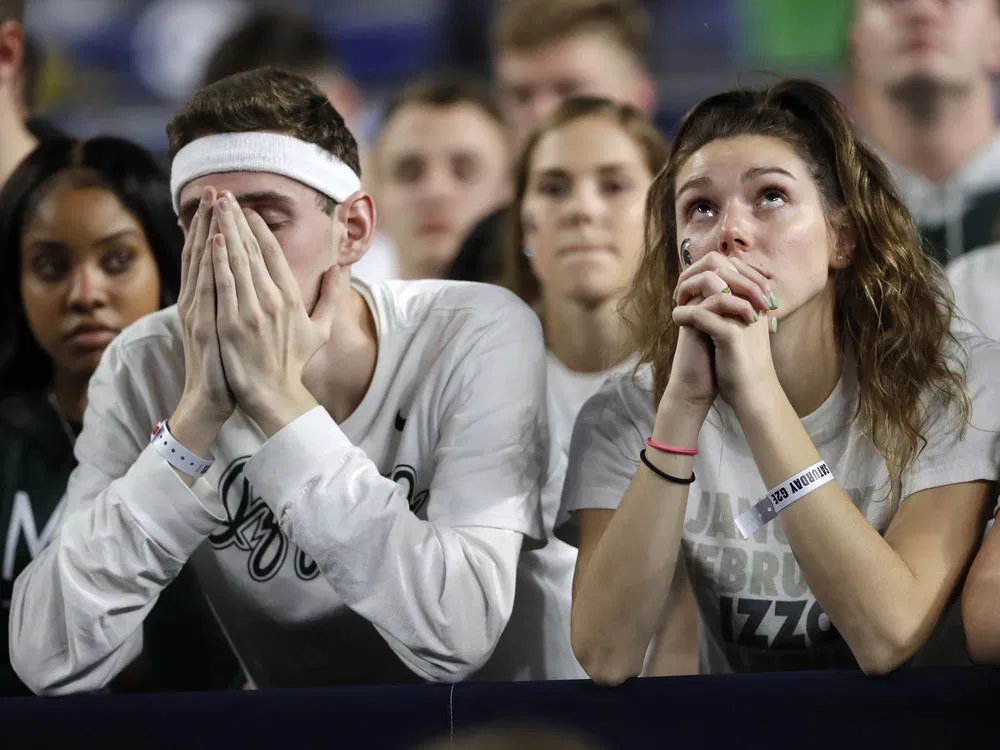
<font size='-1' color="blue">Michigan State fans react at the end of a semifinal round game against Texas Tech in the Final Four NCAA college basketball tournament, Saturday, April 6, 2019, in Minneapolis. *Charlie Neibergall / AP (after <a href='https://nationalpost.com/pmn/sports-pmn/basketball-sports-pmn/michigan-st-endures-more-final-four-heartbreak-vs-texas-tech'>National Post</a>)*</font>

In [ ]:
# march madness women
women_mm_df = pd.read_csv('{}/WDataFiles_Stage2/WNCAATourneyCompactResults.csv'.format(csv_base))
women_mm_thrill_df = pd.merge(women_mm_df, women_thrill_df, on=['Season', 'WTeamID', 'LTeamID', 'DayNum'])

women_ranking_mm = rank_teams_by_thrill(women_mm_thrill_df, 'W')
style1 = '<span style="color:#ffc125"><strong><font size="6">'
style2 = '<span style="color:#C0C0C0"><strong><font size="6">'
style3 = '<span style="color:#cd7f32"><strong><font size="6">'
style_end = '</font></strong></span>'
Markdown("# March Madness women's THRILL ranking<br/><br/>{}1. {} ({}){}<br/><br/>{}2. {} ({}){}<br/><br/>{}3. {} ({}){}<br/><br/><br/><br/>".format(
    style1, women_ranking_mm.loc[0, 'TeamName'], round(women_ranking_mm.loc[0, 'AvgGameThrill'], 1), style_end,
    style2, women_ranking_mm.loc[1, 'TeamName'], round(women_ranking_mm.loc[1, 'AvgGameThrill'], 1), style_end,
    style3, women_ranking_mm.loc[2, 'TeamName'], round(women_ranking_mm.loc[2, 'AvgGameThrill'], 1), style_end,
))

In [ ]:
# march madness men
men_mm_df = pd.read_csv('{}/MDataFiles_Stage2/MNCAATourneyCompactResults.csv'.format(csv_base))
men_mm_thrill_df = pd.merge(men_mm_df, men_thrill_df, on=['Season', 'WTeamID', 'LTeamID', 'DayNum'])

men_ranking_mm = rank_teams_by_thrill(men_mm_thrill_df, 'M')
style1 = '<span style="color:#ffc125"><strong><font size="6">'
style2 = '<span style="color:#C0C0C0"><strong><font size="6">'
style3 = '<span style="color:#cd7f32"><strong><font size="6">'
style_end = '</font></strong></span>'
Markdown("# March Madness men's THRILL ranking<br/><br/>{}1. {} ({}){}<br/><br/>{}2. {} ({}){}<br/><br/>{}3. {} ({}){}<br/><br/><br/><br/>".format(
    style1, men_ranking_mm.loc[0, 'TeamName'], round(men_ranking_mm.loc[0, 'AvgGameThrill'], 1), style_end,
    style2, men_ranking_mm.loc[1, 'TeamName'], round(men_ranking_mm.loc[1, 'AvgGameThrill'], 1), style_end,
    style3, men_ranking_mm.loc[2, 'TeamName'], round(men_ranking_mm.loc[2, 'AvgGameThrill'], 1), style_end,
))

# My Godness me!!!

## March Madness' THRILL factor is so huge comparing to the regular season! It is a real <font color="red">MADNESS</font>.

Surprisingly a women's team Drake Bulldogs plays in the most thrilling way in the March Madness tourney (even men are unable to reach this level of thrill).

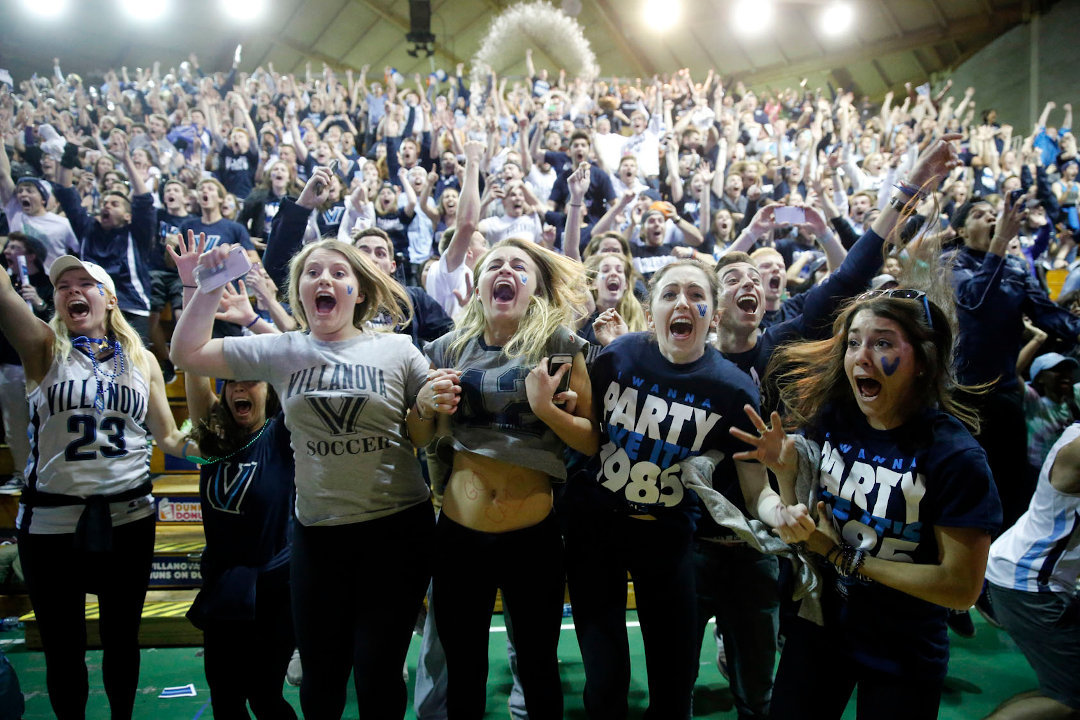
<font size='-1' color="blue">Villanova basketball fans celebrate after Villanova defeated North Carolina. *AP (after <a href='https://www.foxsports.com.au/basketball/villanova-fans-across-the-us-react-to-kris-jenkins-ncaa-championship-winning-buzzerbeater/news-story/b58d717fb6366930f8d89ea006925366'>FoxSports</a>)*</font>